In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### compute Checker Task accuracy for different sets of trials
Easy, Med, Hard are all in main grid, different positions relative to boundaries


In [6]:
n_tasks = 3

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist[is_main_grid])
        
        is_medium = is_main_grid & (dist==0.8)
        is_easy = is_main_grid & (dist==2.4)
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


#### Get confidence for hardest trials

For the hardest trials, the average confidence values are generated by resampling 
the center grid trials so that the distribution of stims is more even across tasks.

this is done in bootstrap_confidence.py (i saved it to disk because it takes ~10 minutes to run)

In [17]:
import bootstrap_confidence
bootstrap_confidence.bootstrap_binary_hardtrials_include_checker(n_boot_iter=1000)

0
1
2
3
4
5
6


In [18]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_include_checker_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

conf_hardtrials = np.mean(signedconf_hardtrials_boot[:,:,:,2:3,:], axis=4)


In [19]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

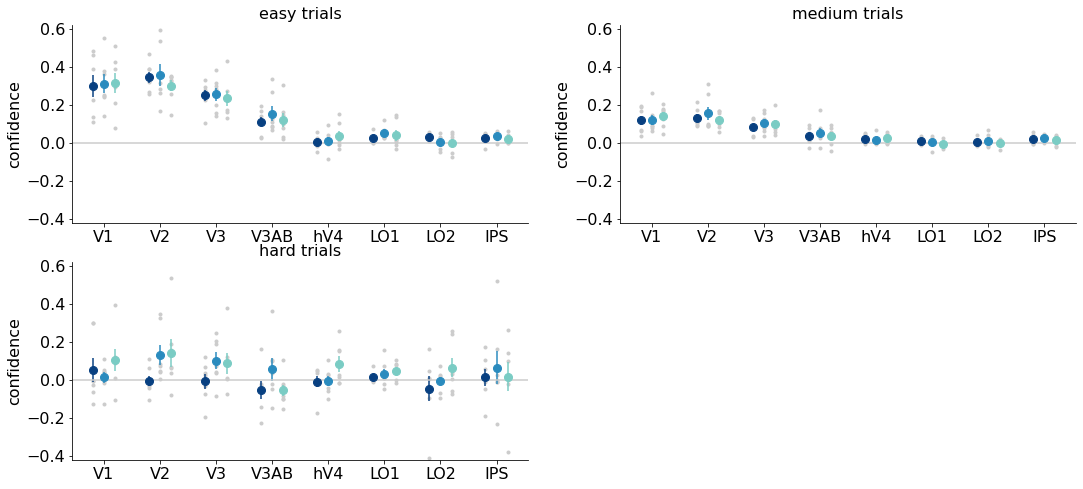

In [21]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,8))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0

for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials,], \
                     ['easy trials','medium trials', 'hard trials']):

    pi+=1
    ax = plt.subplot(2,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    ylims = [-0.42, 0.62]
    # ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)

    figname = os.path.join(figfolder, 'checker_confidence.pdf')
    plt.savefig(figname)

In [15]:
for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['easy trials','medium trials','hard trials']):

    vals = rvals[:,:,:,0]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence,  %s'%(name))
    print(anova_result)



Anova for confidence,  easy trials
            F Value  Num DF  Den DF  Pr > F
roi       42.190647     7.0    42.0  0.0000
task       0.534460     2.0    12.0  0.5993
roi:task   0.596872    14.0    84.0  0.8604

Anova for confidence,  medium trials
            F Value  Num DF  Den DF  Pr > F
roi       22.249921     7.0    42.0   0.000
task       0.739203     2.0    12.0   0.498
roi:task   0.778586    14.0    84.0   0.689

Anova for confidence,  hard trials
           F Value  Num DF  Den DF  Pr > F
roi       2.245077     7.0    42.0  0.0493
task      1.346464     2.0    12.0  0.2968
roi:task  0.829688    14.0    84.0  0.6354
